In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
import useful_functions
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV


In [2]:
#Reading Data
train_df = useful_functions.get_normalized_train()
val_df = useful_functions.get_normalized_val()
test_df = useful_functions.get_normalized_test()

X_train = train_df.drop(columns=['smoking']).to_numpy()
y_train = train_df['smoking'].to_numpy()

X_val = val_df.drop(columns=['smoking']).to_numpy()
y_val = val_df['smoking'].to_numpy()

X_test = test_df.drop(columns=['smoking']).to_numpy()
y_test = test_df['smoking'].to_numpy()

## **Boosting**

### Adaboost With Decision Stumps

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier

class MyAdaBoostTree(BaseEstimator):
    def __init__(self, num_iterations=10, max_tree_height = 1):
        self.num_iterations = num_iterations
        self.max_tree_height = max_tree_height

    def train(self, X, y):
        return self.fit(X,y)

    def fit(self, X, y):
        num_samples = X.shape[0]
        self.alphas__ = []
        self.models__ = []
        sample_weights = np.ones((num_samples))/num_samples
        for iteration in range(self.num_iterations):
            weak_learner = DecisionTreeClassifier(criterion='gini', max_depth=self.max_tree_height)
            weak_learner.fit(X, y, sample_weight=sample_weights)

            sample_predictions = weak_learner.predict(X)
            incorrect = (sample_predictions != y)*1 #Multiply by 1 to convert True/False to 1/0
            weighted_error = np.multiply(incorrect, sample_weights).sum()  / sample_weights.sum()
            alpha = (0.5) * math.log((1-weighted_error) / weighted_error)
            
            #Add Model and Alpha to Ensemble
            self.alphas__.append(alpha)
            self.models__.append(weak_learner)
            
            #Update Weights
            sample_weights = np.multiply(sample_weights, np.exp(2*alpha*incorrect))
            sample_weights = sample_weights / sample_weights.sum()
    
    def predict(self, X):
        sum_predictions = np.zeros(X.shape[0])
        for idx, model in enumerate(self.models__):
            prediction = model.predict(X)
            sum_predictions += self.alphas__[idx] * np.where(prediction == 0, -1, prediction)  #np.where used to replace 0s with -1s      
        return np.where(sum_predictions >= 0, 1, 0)
    

    def score(self, X, y):
        prediction = self.predict(X)
        return (prediction == y).sum()/  X.shape[0] 

    def best_score_(self):
        return self

### Adaboost With Logistic Regression

In [4]:
class MyAdaBoostLogistic(BaseEstimator):
    def __init__(self, num_iterations=10):
        self.num_iterations = num_iterations

    def fit(self, X, y):
        num_samples = X.shape[0]
        self.alphas_ = []
        self.models_ = []
        sample_weights = np.ones((num_samples))/num_samples
        for iteration in range(self.num_iterations):
            weak_learner = LogisticRegression()
            weak_learner.fit(X, y, sample_weight=sample_weights)

            sample_predictions = weak_learner.predict(X)
            incorrect = (sample_predictions != y)*1 #Multiply by 1 to convert True/False to 1/0
            weighted_error = np.multiply(incorrect, sample_weights).sum()  / sample_weights.sum()
            alpha = (0.5) * math.log((1-weighted_error) / weighted_error)
            
            #Add Model and Alpha to Ensemble
            self.alphas_.append(alpha)
            self.models_.append(weak_learner)
            
            #Update Weights
            sample_weights = np.multiply(sample_weights, np.exp(2*alpha*incorrect))
            sample_weights = sample_weights / sample_weights.sum()
    
    def predict(self, X):
        sum_predictions = np.zeros(X.shape[0])
        for idx, model in enumerate(self.models_):
            prediction = model.predict(X)
            sum_predictions += self.alphas_[idx] * np.where(prediction == 0, -1, prediction)        
        return np.where(sum_predictions >= 0, 1, 0)
    

    def score(self, X, y):
        prediction = self.predict(X)
        return (prediction == y).sum()/ X.shape[0]  
    

    def score(self, X, y):
        prediction = self.predict(X)
        return (prediction == y).sum()/ X.shape[0]  

## **Random Forest**

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from collections import Counter

class MyRandomForest(BaseEstimator):
    def __init__(self, num_trees=10, max_height=5, max_features=5):
        self.num_trees = num_trees
        self.max_height = max_height
        self.max_features = max_features
        
    def fit(self, X, y):
        self.trees_ = [] 
        num_samples = X.shape[0]       
        for i in range(self.num_trees):
            samples = np.random.choice(num_samples, size=num_samples, replace=True)
            sampled_X = X[samples]
            sampled_Y = y[samples]
            tree = DecisionTreeClassifier(max_depth=self.max_height, max_features=self.max_features)
            tree.fit(sampled_X, sampled_Y)
            self.trees_.append(tree)


    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees_])     
        mode_predictions =np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
        return mode_predictions
    

    def score(self, X, y):
        prediction = self.predict(X)
        return (prediction == y).sum()/  X.shape[0]   
    
    def train(self, X, y):
        return self.fit(X, y)

## **Bagging**

### Bagging With Decision Trees

In [6]:
## Implementing Bagging from scratch
from collections import Counter
from sklearn.base import BaseEstimator

class MyBagging(BaseEstimator):
    def __init__(self, num_trees=10, max_height=5):
        self.num_trees = num_trees
        self.max_height = max_height    

    def fit(self, X, y):
        self.trees = []
        num_samples  = X.shape[0]        
        for i in range(self.num_trees):
            samples = np.random.choice(num_samples, size=num_samples, replace=True)
            sampled_X = X[samples]
            sampled_Y = y[samples]
            tree = DecisionTreeClassifier(max_depth=self.max_height)
            tree.fit(sampled_X, sampled_Y)
            self.trees.append(tree)

    # calculate the prediction of each tree and return the maximum voted prediction
    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        mode_predictions =np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
        return mode_predictions
    
    def score(self, X, y):
        prediction = self.predict(X)
        return (prediction == y).sum()/  X.shape[0]
    
    def train(self, X, y):
        return self.fit(X, y)
    


### Bagging with KNN

In [7]:
## Bagging using KNN from scratch
from sklearn.neighbors import KNeighborsClassifier

class MyBaggingKNN(BaseEstimator):
    def __init__(self, num_models=10, k=3):
        self.num_models = num_models
        self.k = k

    def fit(self, X_train, y_train):
        self.models = []
        num_samples  = X_train.shape[0]        
        for i in range(self.num_models):
            samples = np.random.choice(num_samples, size=num_samples, replace=True)
            sampled_X = X_train[samples]
            sampled_Y = y_train[samples]
            model = KNeighborsClassifier(n_neighbors=self.k)
            model.fit(sampled_X, sampled_Y)
            self.models.append(model)


    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        mode_predictions =np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
        return mode_predictions
    

    def score(self, X, y):
        prediction = self.predict(X)
        return (prediction == y).sum()/  X.shape[0]
    

    def train(self, X, y):
        return self.fit(X,y)


## **Hyperparameter tuning**

### Grid Search From Scratch (With Threads)

In [8]:
# Implementing Grid Search from scratch using threads
from sklearn.model_selection import ParameterGrid
from threading import Thread


class MyGridSearch():
    def __init__(self, model, params, cv):
        self.model = model
        self.params = params
        self.cv = cv
        self.best_model = None
        self.best_score = 0
        self.best_params = None
        self.predictions = []

    def worker(self,model, X_train, y_train, X_val, y_val):
        print(f"size of X_train: {X_train.shape}")
        print(f"size of X_val: {X_val.shape}")
        model.train(X_train, y_train)
        self.predictions.append((model.score(X_val, y_val), model.get_params()))

    def grid_search(self):
        parameters_grid = ParameterGrid(self.params)
        number_of_models = len(parameters_grid)
        print(f"Number of models: {number_of_models}")
        for i in range(number_of_models):
            # set the parameters for the model
            self.model.set_params(**parameters_grid[i])
            # Create a thread for each model
            training_ratio = (self.cv - 1)  / self.cv
            X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train, y_train, train_size=training_ratio, random_state=42)
            t = Thread(target=self.worker, args=(self.model, X_train_new, y_train_new, X_val_new, y_val_new))
            t.start()
            t.join()
        return max(self.predictions)
            


In [9]:
adaboost = MyAdaBoostTree(num_iterations= 100)
clf = MyGridSearch(adaboost, {"num_iterations": [10, 20, 30, 40, 50]}, 5)
print(clf.grid_search())

#randomForest = MyRandomForest(num_trees=50, max_height=12, max_features=3, num_samples=num_samples)
#clf = MyGridSearch(randomForest, {"num_trees": [10, 20, 30, 40, 50]}, 5)
#print(clf.grid_search())

#bagging = MyBagging(num_trees=10, max_height=12, max_features=3)
#clf = MyGridSearch(bagging, {"num_trees": [10, 20, 30, 40, 50]}, 5)
#print(clf.grid_search())


Number of models: 5
size of X_train: (98260, 8)
size of X_val: (24565, 8)
size of X_train: (98260, 8)
size of X_val: (24565, 8)
size of X_train: (98260, 8)
size of X_val: (24565, 8)
size of X_train: (98260, 8)
size of X_val: (24565, 8)
size of X_train: (98260, 8)
size of X_val: (24565, 8)
(0.7375127213515164, {'max_tree_height': 1, 'num_iterations': 50})


In [10]:
# Hyperparameter Tuning using Grid Search
from sklearn.model_selection import GridSearchCV

# Grid Search for Boosting
adaboost = MyAdaBoostTree(num_samples, num_features)
parameters = {'num_iterations': [10, 20, 50, 100, 200, 300, 400, 500]}
cv=5
clf = MyGridSearch(adaboost, parameters, cv=cv)
print(clf.best_params_)
print(clf.best_score_)
print(clf.score(X_val, y_val))

# Grid Search for Random Forest
forest = MyRandomForest(num_trees=50, max_height=12, max_features=3, num_samples=num_samples)
parameters = {'num_trees': [10, 20, 50, 100, 200, 300, 400, 500]}
clf = GridSearchCV(forest, parameters, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)
print(clf.score(X_val, y_val))

# Grid Search for Bagging
#bagging = MyBagging(num_trees=10, max_height=12, max_features=3)
#parameters = {'num_trees': [10, 20, 50, 100, 200, 300, 400, 500]}
#clf = GridSearchCV(bagging, parameters, cv=5)
#clf.fit(X_train, y_train)
#print(clf.best_params_)
#print(clf.best_score_)
parameters = {'num_iterations': [10, 20, 30]}
clf = GridSearchCV(adaboost, parameters, cv=2)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)
print(clf.score(X_val, y_val))

NameError: name 'num_samples' is not defined

### Grid Search (Sklearn)

Boosting Decision Tree

In [51]:
# Hyperparameter Tuning using Grid Search
from sklearn.model_selection import GridSearchCV

# Grid Search for Boosting
adaboost = MyAdaBoostTree()
hyperparameters = {'num_iterations': [10, 20, 50, 100, 200, 300], 'max_tree_height': [1,2,3]}
clf = GridSearchCV(adaboost, hyperparameters, cv=2, verbose=1)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)
print(clf.score(X_val, y_val))

print(f"Mean cross-validated training accuracy score: {clf.best_score_}\n")
print(f"Best Hyperparameter Combination: {clf.best_params_}\n")
print(f"Validation Score: {clf.score(X_val, y_val)}\n")

val_boost_tree_grid = clf.score(X_val, y_val)


Fitting 2 folds for each of 18 candidates, totalling 36 fits
{'max_tree_height': 3, 'num_iterations': 300}
0.7467290889979337
0.750031395202813
Mean cross-validated training accuracy score: 0.7467290889979337

Best Hyperparameter Combination: {'max_tree_height': 3, 'num_iterations': 300}

Validation Score: 0.750031395202813



Boosting Logistic Regression

In [53]:
# Hyperparameter Tuning using Grid Search
from sklearn.model_selection import GridSearchCV

# Grid Search for Boosting
adaboost = MyAdaBoostLogistic()
hyperparameters = {'num_iterations': [10, 20, 50, 100, 200, 300]}
clf = GridSearchCV(adaboost, hyperparameters, cv=2, verbose=2)
clf.fit(X_train, y_train)
print(f"Mean cross-validated training accuracy score: {clf.best_score_}\n")
print(f"Best Hyperparameter Combination: {clf.best_params_}\n")
print(f"Validation Score: {clf.score(X_val, y_val)}\n")


val_boost_logistic_grid = clf.score(X_val, y_val)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END ..................................num_iterations=10; total time=   0.4s
[CV] END ..................................num_iterations=10; total time=   0.3s
[CV] END ..................................num_iterations=20; total time=   0.9s
[CV] END ..................................num_iterations=20; total time=   1.6s
[CV] END ..................................num_iterations=50; total time=   2.3s
[CV] END ..................................num_iterations=50; total time=   3.1s
[CV] END .................................num_iterations=100; total time=   4.2s
[CV] END .................................num_iterations=100; total time=   3.2s
[CV] END .................................num_iterations=200; total time=   7.3s
[CV] END .................................num_iterations=200; total time=   7.0s
[CV] END .................................num_iterations=300; total time=  10.1s
[CV] END .................................num_ite

Random Forest

In [55]:
# Hyperparameter Tuning using Grid Search
from sklearn.model_selection import GridSearchCV

# Grid Search for Boosting
forest = MyRandomForest()
hyperparameters = {'num_trees': [10, 20, 30, 40, 50], 'max_height':[3, 5, 10]}
clf = GridSearchCV(forest, hyperparameters, cv=2, verbose=1)
clf.fit(X_train, y_train)
print(f"Mean cross-validated training accuracy score: {clf.best_score_}\n")
print(f"Best Hyperparameter Combination: {clf.best_params_}\n")
print(f"Validation Score: {clf.score(X_val, y_val)}\n")


val_forest_grid = clf.score(X_val, y_val)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
Mean cross-validated training accuracy score: 0.7485365394169421

Best Hyperparameter Combination: {'max_height': 10, 'num_trees': 30}

Validation Score: 0.7497174431746829



Bagging

In [56]:
# Hyperparameter Tuning using Grid Search
from sklearn.model_selection import GridSearchCV

# Grid Search for Boosting
bagging = MyBagging()
hyperparameters = {'num_trees': [10, 20], 'max_height':[3, 5, 10]}
clf = GridSearchCV(bagging, hyperparameters, cv=2, verbose=1)
clf.fit(X_train, y_train)
print(f"Mean cross-validated training accuracy score: {clf.best_score_}\n")
print(f"Best Hyperparameter Combination: {clf.best_params_}\n")
print(f"Validation Score: {clf.score(X_val, y_val)}\n")


val_bagging_grid = clf.score(X_val, y_val)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Mean cross-validated training accuracy score: 0.7473397230846132

Best Hyperparameter Combination: {'max_height': 10, 'num_trees': 20}

Validation Score: 0.7510360416928293



In [33]:
# Hyperparameter Tuning using Grid Search
from sklearn.model_selection import GridSearchCV

# Grid Search for BaggingKNN
bagging = MyBaggingKNN()
hyperparameters = {'num_models': [3, 5], 'k':[3, 5]}
clf = GridSearchCV(bagging, hyperparameters, cv=2, verbose=2)
clf.fit(X_train, y_train)
print(f"Mean cross-validated training accuracy score: {clf.best_score_}\n")
print(f"Best Hyperparameter Combination: {clf.best_params_}\n")
print(f"Validation Score: {clf.score(X_val, y_val)}\n")


val_bagging_knn_grid = clf.score(X_val, y_val)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ..................................k=3, num_models=3; total time=  23.5s
[CV] END ..................................k=3, num_models=3; total time=  23.6s
[CV] END ..................................k=3, num_models=5; total time=  30.9s
[CV] END ..................................k=3, num_models=5; total time=  28.6s
[CV] END ..................................k=5, num_models=3; total time=  18.6s
[CV] END ..................................k=5, num_models=3; total time=  20.2s
[CV] END ..................................k=5, num_models=5; total time=  34.0s
[CV] END ..................................k=5, num_models=5; total time=  25.7s
{'k': 5, 'num_models': 5}
0.7055974036626869
0.7110385533090544


### **Random Search**

In [34]:
#Hyperparameter tuning using Random Search for AdaboostTree
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

hyperparameters = {'num_iterations': [10, 15, 20, 25, 30,  35, 40, 45, 50],
                   'max_tree_height': [1,2,3,4,5]}
adaboost = MyAdaBoostTree()
rs = RandomizedSearchCV(adaboost, hyperparameters,cv=2, verbose=2, random_state=42)
rs.fit(X_train, y_train)
print(f"Mean cross-validated training accuracy score: {rs.best_score_}\n")
print(f"Best Estimator: {rs.best_estimator_}\n")
print(f"Best Hyperparameter Combination: {rs.best_params_}\n")
print(f"Validation Score: {rs.score(X_val, y_val)}\n")

val_boost_tree_rand = rs.score(X_val, y_val)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...............max_tree_height=1, num_iterations=40; total time=   2.5s
[CV] END ...............max_tree_height=1, num_iterations=40; total time=   4.1s
[CV] END ...............max_tree_height=1, num_iterations=40; total time=   4.0s
[CV] END ...............max_tree_height=1, num_iterations=40; total time=   3.7s
[CV] END ...............max_tree_height=1, num_iterations=40; total time=   4.6s
[CV] END ...............max_tree_height=1, num_iterations=30; total time=   2.8s
[CV] END ...............max_tree_height=1, num_iterations=30; total time=   2.2s
[CV] END ...............max_tree_height=1, num_iterations=30; total time=   3.6s
[CV] END ...............max_tree_height=1, num_iterations=30; total time=   3.1s
[CV] END ...............max_tree_height=1, num_iterations=30; total time=   3.2s
[CV] END ...............max_tree_height=2, num_iterations=50; total time=   7.2s
[CV] END ...............max_tree_height=2, num_i

In [39]:
#Hyperparameter tuning using Random Search for AdaboostTree
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

hyperparameters = {'num_iterations': [3, 5, 10, 15, 20, 25, 30, 35, 40,45, 50]}
adaboost = MyAdaBoostLogistic()
rs = RandomizedSearchCV(adaboost, hyperparameters, cv=2, verbose=2, random_state=42)
rs.fit(X_train, y_train)
print(f"Mean cross-validated training accuracy score: {rs.best_score_}\n")
print(f"Best Estimator: {rs.best_estimator_}\n")
print(f"Best Hyperparameter Combination: {rs.best_params_}\n")
print(f"Validation Score: {rs.score(X_val, y_val)}\n")


val_boost_logistic_rand = rs.score(X_val, y_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..................................num_iterations=25; total time=   1.3s
[CV] END ..................................num_iterations=25; total time=   1.4s
[CV] END ..................................num_iterations=25; total time=   1.7s
[CV] END ..................................num_iterations=25; total time=   1.3s
[CV] END ..................................num_iterations=25; total time=   1.1s
[CV] END ...................................num_iterations=3; total time=   0.1s
[CV] END ...................................num_iterations=3; total time=   0.2s
[CV] END ...................................num_iterations=3; total time=   0.4s
[CV] END ...................................num_iterations=3; total time=   0.4s
[CV] END ...................................num_iterations=3; total time=   0.2s
[CV] END ..................................num_iterations=45; total time=   3.3s
[CV] END ..................................num_i

In [40]:
#Hyperparameter tuning using Random Search for Random Forest
hyperparameters = {'num_trees': [10, 20, 50, 100, 200, 500],
                    'max_height':[3, 5, 10], 
                    'max_features': [1,2,3,4,5]}
forest = MyRandomForest()
rs = RandomizedSearchCV(forest, hyperparameters, cv=2, verbose=2, random_state=42)
rs.fit(X_train, y_train)
print(f"Mean cross-validated training accuracy score: {rs.best_score_}\n")
print(f"Best Estimator: {rs.best_estimator_}\n")
print(f"Best Hyperparameter Combination: {rs.best_params_}\n")
print(f"Validation Score: {rs.score(X_val, y_val)}\n")

val_forest_rand = rs.score(X_val, y_val)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END ........max_features=3, max_height=3, num_trees=200; total time=  20.0s
[CV] END ........max_features=3, max_height=3, num_trees=200; total time=  14.6s
[CV] END ........max_features=2, max_height=3, num_trees=200; total time=  12.4s
[CV] END ........max_features=2, max_height=3, num_trees=200; total time=  15.2s
[CV] END .........max_features=4, max_height=3, num_trees=20; total time=   3.0s
[CV] END .........max_features=4, max_height=3, num_trees=20; total time=   3.1s
[CV] END .......max_features=4, max_height=10, num_trees=200; total time=  46.2s
[CV] END .......max_features=4, max_height=10, num_trees=200; total time=  47.2s
[CV] END .........max_features=1, max_height=3, num_trees=10; total time=   1.0s
[CV] END .........max_features=1, max_height=3, num_trees=10; total time=   1.4s
[CV] END .........max_features=2, max_height=5, num_trees=50; total time=   4.5s
[CV] END .........max_features=2, max_height=5, 

In [42]:
#Hyperparameter tuning using Random Search for Random Forest
hyperparameters = {'num_trees': [10, 20, 50, 100, 200, 500],
                    'max_height':[3, 5, 10]}
bagging = MyBagging()
rs = RandomizedSearchCV(bagging, hyperparameters, cv=2, verbose=2, random_state=42)
rs.fit(X_train, y_train)
print(f"Mean cross-validated training accuracy score: {rs.best_score_}\n")
print(f"Best Estimator: {rs.best_estimator_}\n")
print(f"Best Hyperparameter Combination: {rs.best_params_}\n")
print(f"Validation Score: {rs.score(X_val, y_val)}\n")


val_bagging_rand = rs.score(X_val, y_val)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END .........................max_height=3, num_trees=10; total time=   1.5s
[CV] END .........................max_height=3, num_trees=10; total time=   2.3s
[CV] END .........................max_height=3, num_trees=20; total time=   3.2s
[CV] END .........................max_height=3, num_trees=20; total time=   2.5s
[CV] END .........................max_height=5, num_trees=50; total time=   9.1s
[CV] END .........................max_height=5, num_trees=50; total time=  10.6s
[CV] END ........................max_height=3, num_trees=500; total time= 1.0min
[CV] END ........................max_height=3, num_trees=500; total time= 1.2min
[CV] END ........................max_height=3, num_trees=100; total time=  13.6s
[CV] END ........................max_height=3, num_trees=100; total time=  14.6s
[CV] END ........................max_height=10, num_trees=20; total time=   8.9s
[CV] END ........................max_height=10, 

### **Bayesian Search**

In [14]:
hyperparameters = {'num_iterations': [10, 15, 20, 25, 30,  35, 40, 45, 50],
                   'max_tree_height': [1,2,3,4,5]}
adaboost = MyAdaBoostTree()
rf = BayesSearchCV(adaboost, hyperparameters, cv=2, verbose=2, random_state=42)
rf.fit(X_train, y_train)
print(f"Mean cross-validated training accuracy score: {rf.best_score_}\n")
print(f"Best Estimator: {rf.best_estimator_}\n")
print(f"Best Hyperparameter Combination: {rf.best_params_}\n")
print(f"Validation Score: {rf.score(X_val, y_val)}\n")

val_boost_tree_bayes = rf.score(X_val, y_val)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
hyperparameters = {'num_iterations': [3, 5, 10, 15, 20, 25, 30, 35, 40,45, 50]}
adaboost = MyAdaBoostLogistic()
rs = BayesSearchCV(adaboost, hyperparameters, cv=2, verbose=2, random_state=42)
rs.fit(X_train, y_train)
print(f"Mean cross-validated training accuracy score: {rs.best_score_}\n")
print(f"Best Estimator: {rs.best_estimator_}\n")
print(f"Best Hyperparameter Combination: {rs.best_params_}\n")
print(f"Validation Score: {rs.score(X_val, y_val)}\n")


val_boost_logistic_bayes = rs.score(X_val, y_val)

In [ ]:
#Hyperparameter tuning using Bayesian Search for Random Forest
hyperparameters = {'num_trees': [10, 20, 50, 100, 200, 500],
                    'max_height':[3, 5, 10], 
                    'max_features': [1,2,3,4,5]}
forest = MyRandomForest()
rs = BayesSearchCV(forest, hyperparameters, cv=2, verbose=2, random_state=42)
rs.fit(X_train, y_train)
print(f"Mean cross-validated training accuracy score: {rs.best_score_}\n")
print(f"Best Estimator: {rs.best_estimator_}\n")
print(f"Best Hyperparameter Combination: {rs.best_params_}\n")
print(f"Validation Score: {rs.score(X_val, y_val)}\n")

val_forest_bayes = rs.score(X_val, y_val)

In [ ]:
#Hyperparameter tuning using Bayesian Search for Random Forest
hyperparameters = {'num_trees': [10, 20, 50, 100, 200, 500],
                    'max_height':[3, 5, 10]}
bagging = MyBagging()
rs = BayesSearchCV(bagging, hyperparameters, cv=2, verbose=2, random_state=42)
rs.fit(X_train, y_train)
print(f"Mean cross-validated training accuracy score: {rs.best_score_}\n")
print(f"Best Estimator: {rs.best_estimator_}\n")
print(f"Best Hyperparameter Combination: {rs.best_params_}\n")
print(f"Validation Score: {rs.score(X_val, y_val)}\n")


val_bagging_bayes = rs.score(X_val, y_val)

### **Comparing Models**

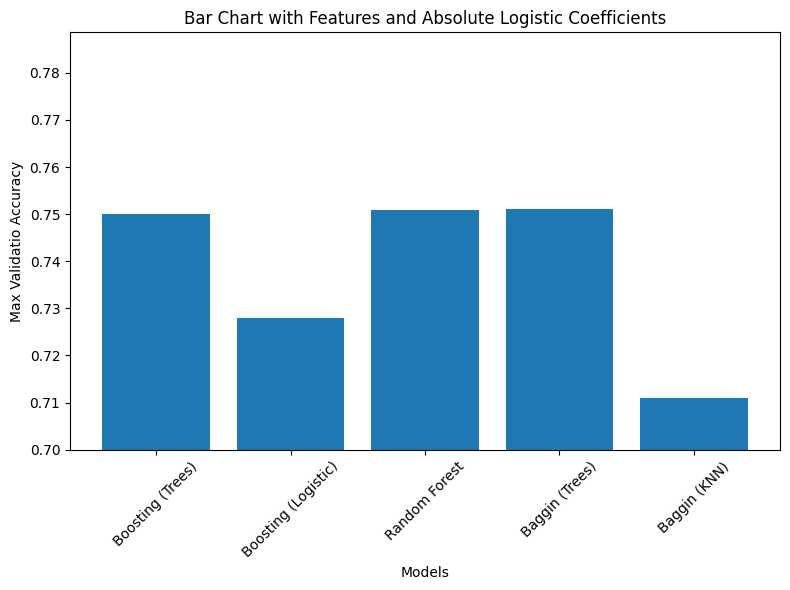

<Figure size 640x480 with 0 Axes>

In [57]:
from matplotlib import pyplot as plt


highest_boosting_tree = max(val_boost_tree_grid, val_boost_tree_rand)
highest_boosting_logistic = max(val_boost_logistic_grid, val_boost_logistic_rand)
highest_forest = max(val_forest_grid, val_forest_rand)
highest_bagging = max(val_bagging_grid, val_bagging_rand)
highest_bagging_knn = val_bagging_knn_grid


model_names =  ["Boosting (Trees)", "Boosting (Logistic)", "Random Forest", "Baggin (Trees)", "Baggin (KNN)"]

plt.figure(figsize=(8, 6))
plt.bar(model_names, [highest_boosting_tree, highest_boosting_logistic, highest_forest, highest_bagging, highest_bagging_knn])
plt.xlabel('Models')
plt.ylabel('Max Validatio Accuracy')
plt.title('Bar Chart with Features and Absolute Logistic Coefficients')
plt.xticks(rotation=45)  
plt.ylim(0.7, plt.ylim()[1]) 
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()


## Performance On Test Data

In [59]:
#Using Random Forest (Best Model)

forest = MyRandomForest(num_trees= 200, max_height= 10, max_features= 4)

forest.fit(X_train, y_train)


final_test_accuracy = forest.score(X_test, y_test)

print("Final Test Accuracy ", final_test_accuracy)



Final Test Accuracy  0.7523546402109758
